In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
tool = TavilySearchResults(max_results=1)
tools = [tool]
# tool.invoke("Where is Cachan")

In [5]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [6]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [7]:
graph_builder.add_node("chatbot", chatbot)

## Basic Tool Node

In [8]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""
    
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
        
    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id = tool_call["id"],
                )
            )
        return {"messages": outputs}     

In [9]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [10]:
from typing import Literal

def route_tools(
        state: State,
) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message

    has tool calls. Otherwise, route to the end."""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

In [11]:
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

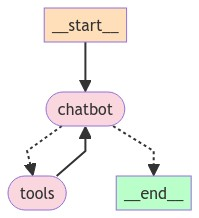

In [12]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


Assistant: Hi there! How can I assist you today?
Assistant: 
Assistant: [{"url": "https://www.ft.com/content/088d3368-bb8b-4ff3-9df7-a7680d4d81b2", "content": "Letter in response to this report:\nPlanetary stress will be mainstream economics / From Jennifer Barker, London SW19, UK\nPromoted Content\nFollow the topics in this article\nComments\nUseful links\nSupport\nLegal & Privacy\nServices\nTools\nCommunity & Events\nMore from the FT Group\nInternational Edition\nTop sections\nFT recommends Cookies on FT Sites\nWe use\ncookies\nand other data for a number of reasons, such as keeping FT Sites reliable and secure,\npersonalising content and ads, providing social media features and to\nanalyse how our Sites are used.\n Global inflation tracker: see how your country compares on rising prices\nValentina Romei and Alan Smith in London\nSimply sign up to the Global inflation myFT Digest -- delivered directly to your inbox.\n This is most likely due to being offline or JavaScript being disab